In [2]:
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import os
import re
import pandas as pd

# Load English NLP model
nlp = spacy.load("en_core_web_sm")

# Define domestic entities (U.S.-related)
domestic_entities = {
    "U.S.", "United States", "USA", "Federal Reserve", "Fed",
    "Treasury", "FOMC", "Committee", "Congress", "White House",
    "American", "New York", "Washington", "Chicago", "San Francisco",
    "Atlanta", "Philadelphia", "Dallas", "Boston", "Richmond", "St. Louis",
    "Cleveland", "Minneapolis", "Kansas City", "Los Angeles", "California",
    "Texas", "Florida", "Illinois", "Ohio", "US", "USD"
}

# Define international entities
international_entities = {
    "China", "Chinese", "Japan", "Japanese", "Germany", "German", "Eurozone",
    "Asia", "Asian", "Mexico", "Mexican", "Canada", "Canadian", "Brazil", "Brazilian",
    "United Kingdom", "UK", "British", "France", "French", "India", "Indian",
    "Russia", "Russian", "Europe", "European", "Australia", "Australian",
    "South Korea", "Korean", "OECD", "IMF", "ECB", "World Bank", "UN", "EU",
    "G7", "G20", "OPEC", "WTO", "NATO", "ASEAN", "Africa", "South Africa",
    "Argentina", "Argentine", "Turkey", "Turkish", "Indonesia", "Indonesian"
}

# Folder with text files
folder_path = "../data/raw/fomc_minutes"

# Collect results
data = []

# Loop over files
for filename in sorted(os.listdir(folder_path)):
    if filename.endswith(".txt"):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read()

        # spaCy processing
        doc = nlp(text)

        # Entity classification
        domestic_mentions = []
        international_mentions = []

        for ent in doc.ents:
            ent_text = ent.text.strip()
            if ent_text in domestic_entities:
                domestic_mentions.append(ent_text)
            elif ent_text in international_entities:
                international_mentions.append(ent_text)

        # Extract YYYY-MM from filename
        date_match = re.search(r"(\d{4})(\d{2})", filename)
        if date_match:
            year_month = f"{date_match.group(1)}-{date_match.group(2)}"
        else:
            year_month = filename

        # Store result
        data.append({
            "month": year_month,
            "domestic_count": len(domestic_mentions),
            "international_count": len(international_mentions)
        })

# Create DataFrame
df = pd.DataFrame(data)
df["month"] = pd.to_datetime(df["month"])
df = df.sort_values("month")
df["total"] = df["domestic_count"] + df["international_count"]
df["intl_share"] = df["international_count"] / df["total"]
df["domestic_share"] = df["domestic_count"] / df["total"]

In [1]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 1.7 MB/s eta 0:00:08
     -- ------------------------------------- 0.8/12.8 MB 1.5 MB/s eta 0:00:09
     --- ------------------------------------ 1.0/12.8 MB 1.4 MB/s eta 0:00:09
     ---- ----------------------------------- 1.3/12.8 MB 1.4 MB/s eta 0:00:09
     ---- ----------------------------------- 1.6/12.8 MB 1.4 MB/s eta 0:00:09
     ----- ---------------------------------- 1.8/12.8 MB 1.4 MB/s eta 0:00:09
     ------ --------------------------------- 2.1/12.8 MB 1.4 MB/s eta 0:00:08
     ------- -------------------------------- 2.4/12.8 MB 1.4 MB/s eta 0:00:08
     -------- ------------------------------- 2.6/12.8 MB 1.4 MB/s eta 0:00:08
     --------- ------------------------------ 2.9/12.8 MB 1.3 MB/s eta 0:00:08
     --------- ------------------------------ 3.1/12.8 MB 1.3 MB/s

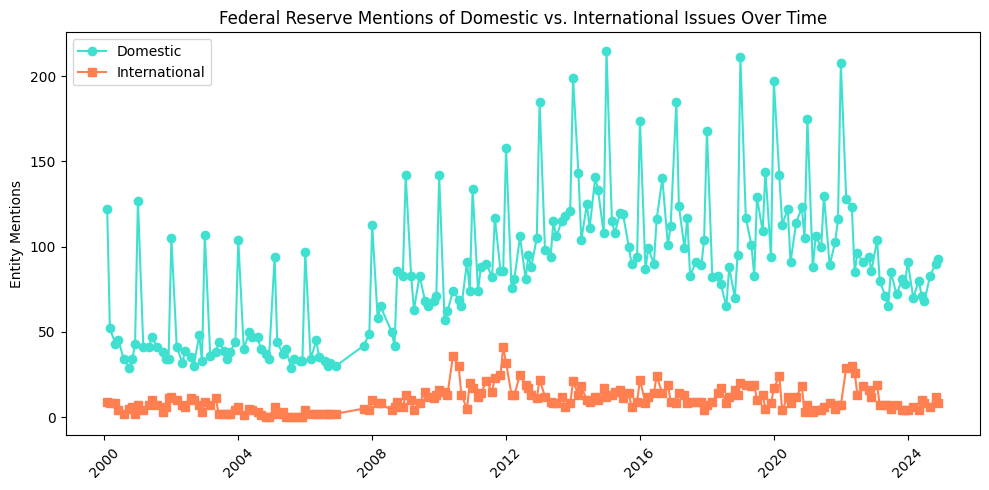

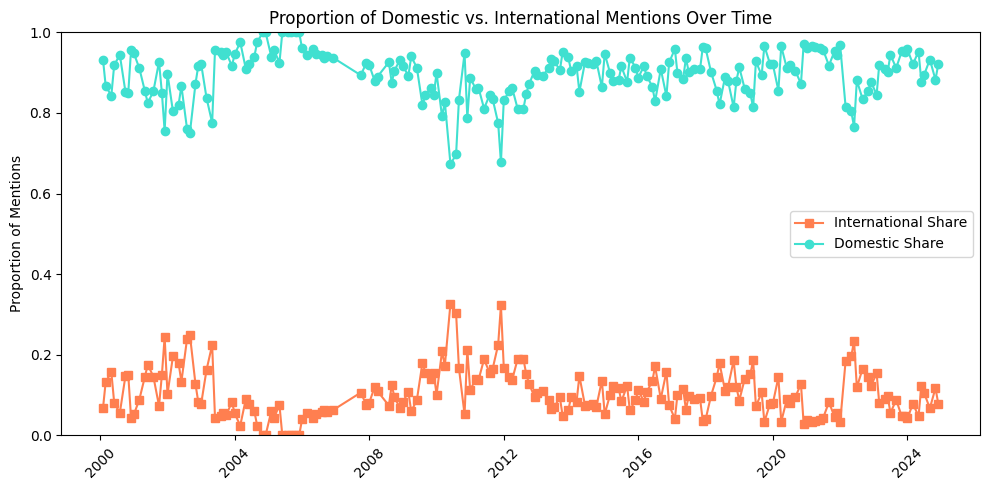

In [3]:
# Plotting counts with custom colors
plt.figure(figsize=(10, 5))
plt.plot(df["month"], df["domestic_count"], label="Domestic", marker='o', color='turquoise')
plt.plot(df["month"], df["international_count"], label="International", marker='s', color='coral')
plt.ylabel("Entity Mentions")
plt.title("Federal Reserve Mentions of Domestic vs. International Issues Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting share with custom colors
plt.figure(figsize=(10, 5))
plt.plot(df["month"], df["intl_share"], label="International Share", marker='s', color='coral')
plt.plot(df["month"], df["domestic_share"], label="Domestic Share", marker='o', color='turquoise')
plt.ylim(0, 1)
plt.ylabel("Proportion of Mentions")
plt.title("Proportion of Domestic vs. International Mentions Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


try:
    text_data = df["text"].dropna().str.cat(sep=" ")
except NameError:
    text_data = fomc_df["text"].dropna().str.cat(sep=" ")

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(text_data)

# Plot the word cloud
plt.figure(figsize=(12, 6), dpi=800)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of FOMC Cleaned Text")
plt.show()

KeyError: 'text'

In [7]:
# ---------- CONFIG -----------------------------------------------------------------
TOP_N            = 170         # or set to None and use MIN_WORD_FREQ instead
MIN_WORD_FREQ    = 1            # ignore words below this doc-frequency
PMI_THRESHOLD    = 0.0          # raise if you want a sparser graph
LABEL_TOP_K      = 0           # label only the K most central nodes
RANDOM_SEED      = 42           # reproducible layouts
# -----------------------------------------------------------------------------------

import pandas as pd, numpy as np, networkx as nx, math, re, itertools, random
from collections import defaultdict, Counter
from wordcloud import STOPWORDS
from community import community_louvain             # python-louvain
from pyvis.network import Network
import matplotlib.pyplot as plt

random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)

# ---------- 1. TEXT PRE-PROCESSING --------------------------------------------------
STOP_SET = STOPWORDS.union({"mr"})                 # extend as needed

# Phrase-level synonyms handled *before* tokenisation
PHRASE_SYNONYMS = {
    r"\bfederal reserve\b": "fed",
}

def normalise_text(x:str) -> str:
    x = x.lower()
    for pat, repl in PHRASE_SYNONYMS.items():
        x = re.sub(pat, repl, x)
    return x

df["text_norm"] = df["text"].fillna("").map(normalise_text)
text_lines = df["text_norm"].str.split("\n").explode().tolist()

# Tokenise & gather frequencies per document line
token_pat   = re.compile(r"\b[a-z]{2,}\b")

def tokens_in_line(line:str):
    toks = token_pat.findall(line)
    return [t for t in toks if t not in STOP_SET]

line_tokens = [tokens_in_line(l) for l in text_lines]
doc_freq    = Counter({w:0 for l in line_tokens for w in set(l)})
for l in line_tokens:
    for w in set(l): doc_freq[w] += 1
N_DOCS = len(line_tokens)

# Select vocabulary
if TOP_N:
    vocab = [w for w,_ in doc_freq.most_common(TOP_N)]
else:
    vocab = [w for w,c in doc_freq.items() if c >= MIN_WORD_FREQ]

# ---------- 2. CO-OCCURRENCE & PMI --------------------------------------------------
vindex   = {w:i for i,w in enumerate(vocab)}
co_mat   = np.zeros((len(vocab), len(vocab)), dtype="int")

for toks in line_tokens:
    toks = [t for t in set(toks) if t in vindex]      # unique tokens per doc
    for w1,w2 in itertools.combinations(toks,2):
        i,j = vindex[w1], vindex[w2]
        co_mat[i,j] += 1
        co_mat[j,i] += 1

def pmi(i,j):
    pw1   = doc_freq[vocab[i]]/N_DOCS
    pw2   = doc_freq[vocab[j]]/N_DOCS
    pw1w2 = co_mat[i,j]/N_DOCS
    if pw1w2 == 0: return 0
    return math.log2(pw1w2/(pw1*pw2))

# ---------- 3. BUILD GRAPH ----------------------------------------------------------
G = nx.Graph()
for i,w in enumerate(vocab):
    G.add_node(w, freq=doc_freq[w])

for i in range(len(vocab)):
    for j in range(i+1,len(vocab)):
        weight = pmi(i,j)
        if weight > PMI_THRESHOLD:
            G.add_edge(vocab[i], vocab[j], weight=weight)

# Louvain communities → colours
partition   = community_louvain.best_partition(G, random_state=RANDOM_SEED)
nx.set_node_attributes(G, partition, "community")

# ---------- 4. CENTRALITY & LABEL SELECTION ----------------------------------------
centrality  = nx.degree_centrality(G)
nx.set_node_attributes(G, centrality, "cent")
label_nodes = set(sorted(centrality, key=centrality.get, reverse=True)[:LABEL_TOP_K])

nx.write_gexf(G, "word_pmi.gexf")

ImportError: cannot import name 'community_louvain' from 'community' (c:\Users\olegv\AppData\Local\Programs\Python\Python312\Lib\site-packages\community\__init__.py)

In [ ]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())